In [1]:
import pandas as pd
import tensorflow_hub as hub
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import plotly.graph_objects as go
from kneed import KneeLocator
import plotly.io as pio


2024-05-28 12:30:19.561784: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-28 12:30:19.563398: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-28 12:30:19.599828: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-28 12:30:19.668084: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-28 12:30:22.639063: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF

In [2]:
df = pd.read_csv("./data/song_lyrics_sampled_proc.csv")
print('Data rows number: ', len(df))
df.head()

Data rows number:  3919


,title,tag,artist,year,lyrics,id,lyrics_proc
0,Toothpick,pop,Biting Elbows,2012,Some folks got the patience of the angels\nNot...,1166787,folk got patience angel heart well yearns veng...
1,6 Feet Under,pop,Ana Johnsson,2004,You just left me 6 feet under ground I'm burni...,803057,left foot ground burning sight light foot buri...
2,The Poetaster Act 4. Scene 2,misc,Ben Jonson,1601,"A Room in Lupus's House.\n\nEnter Lupus, HISTR...",674438,room house enter lupus histrio lictors tuc sta...
3,Hes Gone,pop,Phil Lesh & Friends,2015,"Rat in a drain ditch, caught on a limb, you kn...",961823,rat drain ditch caught limb know better know l...
4,Ill Never Say,pop,Helen Ward,2015,"I'll never say ""never again"" again\nCause here...",1163619,never say never cause love head heel love neve...


### Load USE with TF

In [3]:
# Load the Universal Sentence Encoder module (transformer-based variant)
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
use = hub.load(module_url)

lyrics_embeddings = df['lyrics_proc'].apply(lambda lyrics: use([lyrics]).numpy()[0])
lyrics_embeddings

2024-05-28 12:30:28.862536: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-05-28 12:30:33.294802: E tensorflow/core/util/util.cc:131] oneDNN supports DT_INT64 only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


0       [-0.056033246, -0.054995343, 0.027326314, 0.01...
1       [-0.052749544, -0.04411805, 0.056027986, 0.040...
2       [-0.014596429, -0.057172682, -0.021360282, 0.0...
3       [-0.048244074, -0.05550254, 0.05564705, 0.0259...
4       [0.03838014, -0.02164263, -0.010910849, -0.042...
                              ...                        
3914    [-0.060502596, -0.059904378, 0.06110249, 0.026...
3915    [-0.056997176, -0.07835833, -0.031518035, 0.07...
3916    [-0.002709979, -0.05377683, 0.056938853, 0.053...
3917    [0.022438658, -0.06232634, 0.06601431, 0.06494...
3918    [-0.05009394, -0.035998333, 0.051654447, -0.00...
Name: lyrics_proc, Length: 3919, dtype: object

In [4]:
df['use_embeddings'] = lyrics_embeddings
df.head()

,title,tag,artist,year,lyrics,id,lyrics_proc,use_embeddings
0,Toothpick,pop,Biting Elbows,2012,Some folks got the patience of the angels\nNot...,1166787,folk got patience angel heart well yearns veng...,"[-0.056033246, -0.054995343, 0.027326314, 0.01..."
1,6 Feet Under,pop,Ana Johnsson,2004,You just left me 6 feet under ground I'm burni...,803057,left foot ground burning sight light foot buri...,"[-0.052749544, -0.04411805, 0.056027986, 0.040..."
2,The Poetaster Act 4. Scene 2,misc,Ben Jonson,1601,"A Room in Lupus's House.\n\nEnter Lupus, HISTR...",674438,room house enter lupus histrio lictors tuc sta...,"[-0.014596429, -0.057172682, -0.021360282, 0.0..."
3,Hes Gone,pop,Phil Lesh & Friends,2015,"Rat in a drain ditch, caught on a limb, you kn...",961823,rat drain ditch caught limb know better know l...,"[-0.048244074, -0.05550254, 0.05564705, 0.0259..."
4,Ill Never Say,pop,Helen Ward,2015,"I'll never say ""never again"" again\nCause here...",1163619,never say never cause love head heel love neve...,"[0.03838014, -0.02164263, -0.010910849, -0.042..."


In [5]:
def find_optimal_pca_dimensions(df, embeddings_column, dimensions, n_clusters=5):
    
    # Extract the embeddings from the DataFrame
    embeddings = np.stack(df[embeddings_column].values)
    
    # Apply Standard Scaler
    scaler = StandardScaler()
    scaled_embeddings = scaler.fit_transform(embeddings)
    
    results = []
    for dim in dimensions: 
        # Apply PCA
        pca = PCA(n_components=dim)
        reduced_embeddings = pca.fit_transform(scaled_embeddings)

        # Cluster the reduced embeddings
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        cluster_labels = kmeans.fit_predict(reduced_embeddings)

        # Compute the Silhouette score
        silhouette_avg = silhouette_score(reduced_embeddings, cluster_labels)

        # Calculate variance preserved
        variance_preserved = np.sum(pca.explained_variance_ratio_)

        # Append results
        results.append({
            'Dimensions': dim,
            'Silhouette Score': silhouette_avg,
            'Variance Preserved': variance_preserved
        })

    return pd.DataFrame(results)

dimensions = [2,3,5,10,15,20,35,50]

table = find_optimal_pca_dimensions(df,'use_embeddings',dimensions)
table

,Dimensions,Silhouette Score,Variance Preserved
0,2,0.395290,0.140073
1,3,0.376386,0.168047
2,5,0.282111,0.212485
3,10,0.197566,0.283916
4,15,0.166312,0.334387
5,20,0.147322,0.375617
6,35,0.116676,0.474357
7,50,0.075231,0.549690


In [6]:
def find_best_tradeoff(results_df):
    
    # Calculate the absolute difference between the normalized metrics
    results_df['Difference'] = np.abs(results_df['Silhouette Score'] - results_df['Variance Preserved'])
    
    # Find the dimension with the minimum difference
    best_dimension = results_df.loc[results_df['Difference'].idxmin(), 'Dimensions']
    
    return best_dimension, results_df

best_dim, _ = find_best_tradeoff(table)
print("The best dimension is: ", best_dim)

# Extract the embeddings from the DataFrame
embeddings = np.stack(df['use_embeddings'].values)

# Apply Standard Scaler
scaler = StandardScaler()
scaled_embeddings = scaler.fit_transform(embeddings)

# Apply PCA
pca = PCA(n_components=best_dim)
reduced_embeddings = pca.fit_transform(scaled_embeddings)

# Add reduced embedding as new column
df['reduced_embeddings'] = list(reduced_embeddings)
df.head()

The best dimension is:  5


,title,tag,artist,year,lyrics,id,lyrics_proc,use_embeddings,reduced_embeddings
0,Toothpick,pop,Biting Elbows,2012,Some folks got the patience of the angels\nNot...,1166787,folk got patience angel heart well yearns veng...,"[-0.056033246, -0.054995343, 0.027326314, 0.01...","[0.81851715, 8.934775, 0.81352615, -2.5656686,..."
1,6 Feet Under,pop,Ana Johnsson,2004,You just left me 6 feet under ground I'm burni...,803057,left foot ground burning sight light foot buri...,"[-0.052749544, -0.04411805, 0.056027986, 0.040...","[-2.9089708, 3.2278922, -1.5783564, -5.951331,..."
2,The Poetaster Act 4. Scene 2,misc,Ben Jonson,1601,"A Room in Lupus's House.\n\nEnter Lupus, HISTR...",674438,room house enter lupus histrio lictors tuc sta...,"[-0.014596429, -0.057172682, -0.021360282, 0.0...","[2.7934358, 6.421314, 4.940535, -2.629096, 0.4..."
3,Hes Gone,pop,Phil Lesh & Friends,2015,"Rat in a drain ditch, caught on a limb, you kn...",961823,rat drain ditch caught limb know better know l...,"[-0.048244074, -0.05550254, 0.05564705, 0.0259...","[0.7794891, 8.609822, 0.43459022, 1.4211658, 0..."
4,Ill Never Say,pop,Helen Ward,2015,"I'll never say ""never again"" again\nCause here...",1163619,never say never cause love head heel love neve...,"[0.03838014, -0.02164263, -0.010910849, -0.042...","[-4.8536816, -0.8248347, -5.674032, 2.2969456,..."


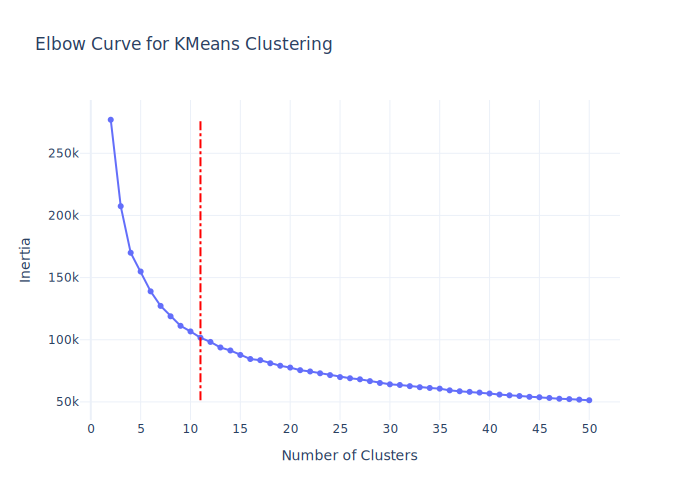

The best number of clusters is:  11


In [7]:
def plot_elbow_curve(df, cluster_range=(2, 50)):
    # Extract the embeddings from the DataFrame
    reduced_embeddings = np.stack(df['reduced_embeddings'].values)

    # Initialize variables to store inertia values
    cluster_range_values = range(cluster_range[0], cluster_range[1] + 1)
    inertia_values = []

    # Compute inertia for each number of clusters
    for n_clusters in cluster_range_values:
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        kmeans.fit(reduced_embeddings)
        inertia_values.append(kmeans.inertia_)
    
    # Use the KneeLocator to find the elbow point
    knee = KneeLocator(cluster_range_values, inertia_values, curve='convex', direction='decreasing')

    # Plot the elbow curve using Plotly
    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x=list(cluster_range_values)[::1],
        y=inertia_values,
        mode='lines+markers',
        name='Inertia'
    ))

    fig.add_shape(
        type="line",
        x0=knee.elbow,
        y0=min(inertia_values),
        x1=knee.elbow,
        y1=max(inertia_values),
        line=dict(
            color="red",
            width=2,
            dash="dashdot",
        ),
    )

    fig.update_layout(
        title='Elbow Curve for KMeans Clustering',
        xaxis_title='Number of Clusters',
        yaxis_title='Inertia',
        xaxis=dict(tickmode='linear', dtick=5),
        template='plotly_white'
    )
    
    # Show the plot
    fig.show("svg")
    # Save plot
    pio.write_image(fig, './plots/use_elbow.pdf')
    return knee.elbow
    
n_clusters = plot_elbow_curve(df)
print("The best number of clusters is: ", n_clusters)

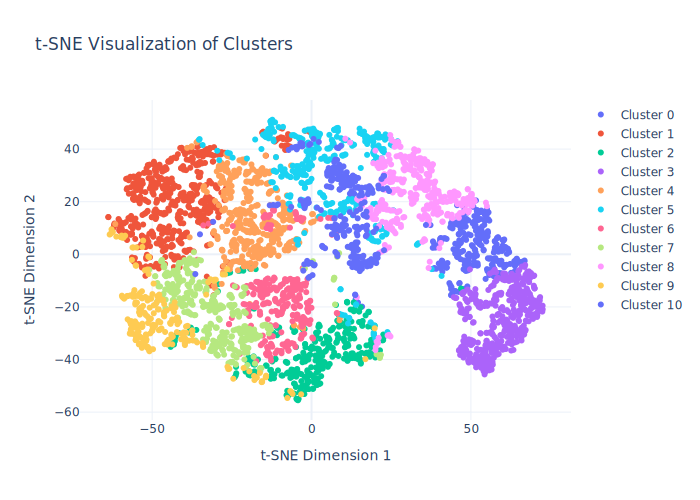

In [8]:
def perform_clustering_and_visualize(df,n_clusters):
    # Extract the embeddings from the DataFrame
    reduced_embeddings = np.stack(df['reduced_embeddings'].values)

    # Apply KMeans clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(reduced_embeddings)

    # Apply t-SNE for visualization
    tsne = TSNE(n_components=2, random_state=42)
    tsne_embeddings = tsne.fit_transform(reduced_embeddings)

    # Create a DataFrame for visualization
    tsne_df = pd.DataFrame(tsne_embeddings, columns=['x', 'y'])
    tsne_df['cluster'] = cluster_labels

    # Create a plotly scatter plot
    fig = go.Figure()

    # Add traces for each cluster
    for cluster in range(n_clusters):
        cluster_df = tsne_df[tsne_df['cluster'] == cluster]
        fig.add_trace(go.Scatter(
            x=cluster_df['x'], y=cluster_df['y'],
            mode='markers',
            name=f'Cluster {cluster}',
            marker=dict(size=6),
            #text=cluster_df.index
        ))

    # Update layout
    fig.update_layout(
        title='t-SNE Visualization of Clusters',
        xaxis_title='t-SNE Dimension 1',
        yaxis_title='t-SNE Dimension 2',
        template='plotly_white',
        showlegend=True
    )

    # Show plot
    fig.show("svg")
    # Save plot
    pio.write_image(fig, './plots/use_tsne.pdf')

    return cluster_labels

cluster_labels = perform_clustering_and_visualize(df, n_clusters)
# Add cluster labels to the lyrics embeddings
df['cluster'] = cluster_labels

In [9]:
def top_n_similar_embeddings(df, target_index, n=10):
    
    # Extract the target embedding and its cluster
    target_embedding = df.at[target_index, 'reduced_embeddings']
    target_cluster = df.at[target_index, 'cluster']
    
    # Filter the DataFrame to get only the embeddings in the same cluster
    cluster_df = df[df['cluster'] == target_cluster]
    cluster_embeddings = np.stack(cluster_df['reduced_embeddings'].values)

    # Calculate cosine similarities
    similarities = cosine_similarity([target_embedding], cluster_embeddings)[0]

    # Get the top n similar embeddings
    top_n_indices = np.argsort(similarities)[-n-1:][::-1]
    top_n_similar_ids = cluster_df.iloc[top_n_indices]['id'].values
    top_n_similarities = similarities[top_n_indices]

    return pd.DataFrame({
        'id': top_n_similar_ids, 
        'similarity': top_n_similarities
    })

# Show top 10 similar song to the first song (the first row is the song itself)
top_n_similar_embeddings(df,target_index=0,n=10)

,id,similarity
0,1166787,1.000000
1,14077,0.994841
2,690440,0.993757
3,924470,0.983981
4,332485,0.979564
5,419566,0.978584
6,1046192,0.975742
7,692176,0.975495
8,96535,0.974763
9,138684,0.971018
